In [43]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from datetime import datetime

# yahoo Finance API library (useful?)
import yfinance as yf

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, LSTM

from pandas_datareader import data as pdr
yf.pdr_override()

In [44]:
stock = 'AMD'

end = datetime.now()
start = datetime(end.year - 3, end.month, end.day)

In [45]:
globals()[stock] = yf.download(stock, start, end)
df_amd = globals()[stock]

[*********************100%%**********************]  1 of 1 completed


## Data Cleaning

In [46]:
df_amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-05-03,81.970001,82.000000,78.459999,78.550003,78.550003,66323300
2021-05-04,77.949997,78.669998,77.040001,78.610001,78.610001,59194300
2021-05-05,79.050003,79.300003,77.360001,77.830002,77.830002,42310200
2021-05-06,77.629997,78.059998,76.470001,77.889999,77.889999,38661300
2021-05-07,78.750000,79.570000,78.220001,78.809998,78.809998,36954200


In [47]:
df_amd.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-04-25,149.149994,155.139999,146.750000,153.759995,153.759995,41471400
2024-04-26,154.240005,158.630005,153.429993,157.399994,157.399994,42510700
2024-04-29,159.080002,160.770004,156.259995,160.199997,160.199997,43478200
2024-04-30,160.630005,162.289993,158.350006,158.380005,158.380005,60742800
2024-05-01,148.110001,151.369995,142.139999,144.270004,144.270004,89413200


In [48]:
df_amd.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 755 entries, 2021-05-03 to 2024-05-01
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       755 non-null    float64
 1   High       755 non-null    float64
 2   Low        755 non-null    float64
 3   Close      755 non-null    float64
 4   Adj Close  755 non-null    float64
 5   Volume     755 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 41.3 KB


In [49]:
df_amd.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

No Cleaning is required.

## Data Analysis

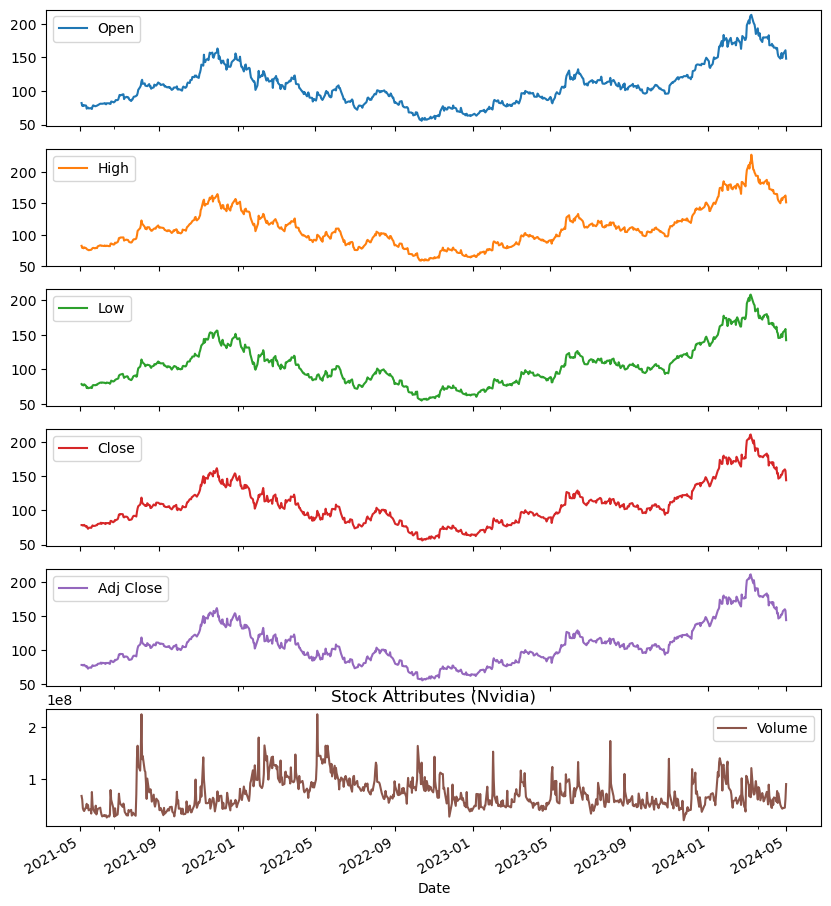

In [50]:
df_amd.plot(subplots = True, figsize=(10,12))
plt.title("Stock Attributes (Nvidia)")
plt.show()

In [51]:
fig = px.line(df_amd, y=['Open', 'Close', 'High', 'Low', 'Adj Close'], title = 'Date vs Stock Prices')
fig.show()

Judging the Closing price, AMD has been experiencing a volatile rise and drop in its price. The most recent drop can be explained with AMD's struggle to impress Wall Street with its earnings season, investors were not impressed even amid the rise in AI demand. Leading to a near 9% drop in stock price and affecting other company stocks such as Nvidia with a 3% stock drop. This may be a good opportunity to take in the semiconductor market to start investing into AMD.

In [52]:
fig = px.line(df_amd, y=['Volume'], title = 'Date vs Stock Prices')
fig.show()

In [53]:
# AMD Candlestick Chart
# Further detailed chart evaluating noticeable drops and rises in data.

fig = go.Figure(data=[go.Candlestick(x=df_amd.index, open=df_amd['Open'], high=df_amd['High'], low=df_amd['Low'], close=df_amd['Close'])])

fig.update_layout(title='Nvidia Stock Price Candlestick Chart', xaxis_title='Date', yaxis_title='Stock Price (USD)')
fig.show()

### Calculation of Moving Average 

In [54]:
ma_day = [10,20,50]

for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_amd[column_name] = df_amd['Adj Close'].rolling(ma).mean()

Text(0.5, 1.0, 'AMD Moving Averages')

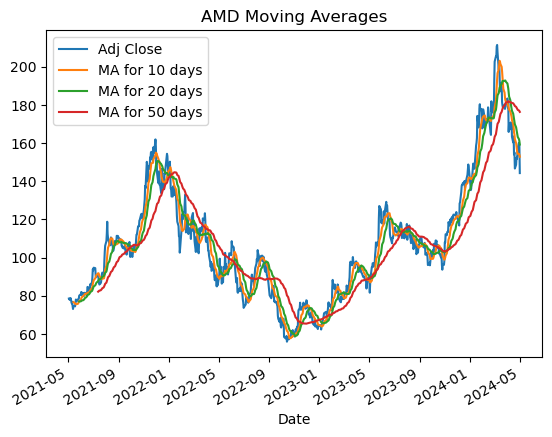

In [55]:
df_amd[['Adj Close', 'MA for 10 days', 'MA for 20 days', 'MA for 50 days']].plot()
plt.title("AMD Moving Averages")

Based on the graph, the best moving average is 10 days and 20 days because they still capture trends in the data before getting too diluted.

Text(0.5, 1.0, 'AMD Daily Return')

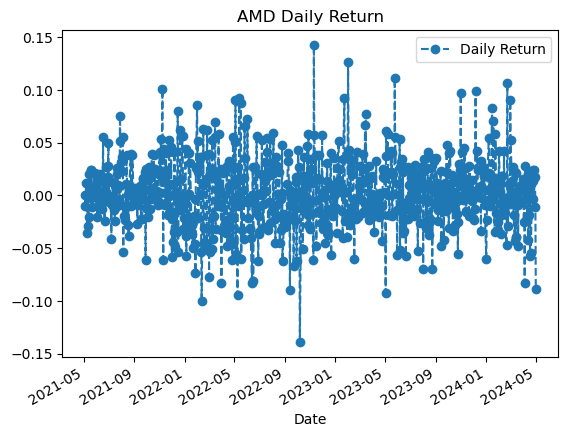

In [56]:
df_amd['Daily Return'] = df_amd['Adj Close'].pct_change()

df_amd['Daily Return'].plot(legend=True, linestyle='--', marker='o')
plt.title("AMD Daily Return")

Will use a histogram to get a better view, but this data will be used to analyze the possible risk factor for the stock

Text(0.5, 1.0, 'AMD Daily Return')

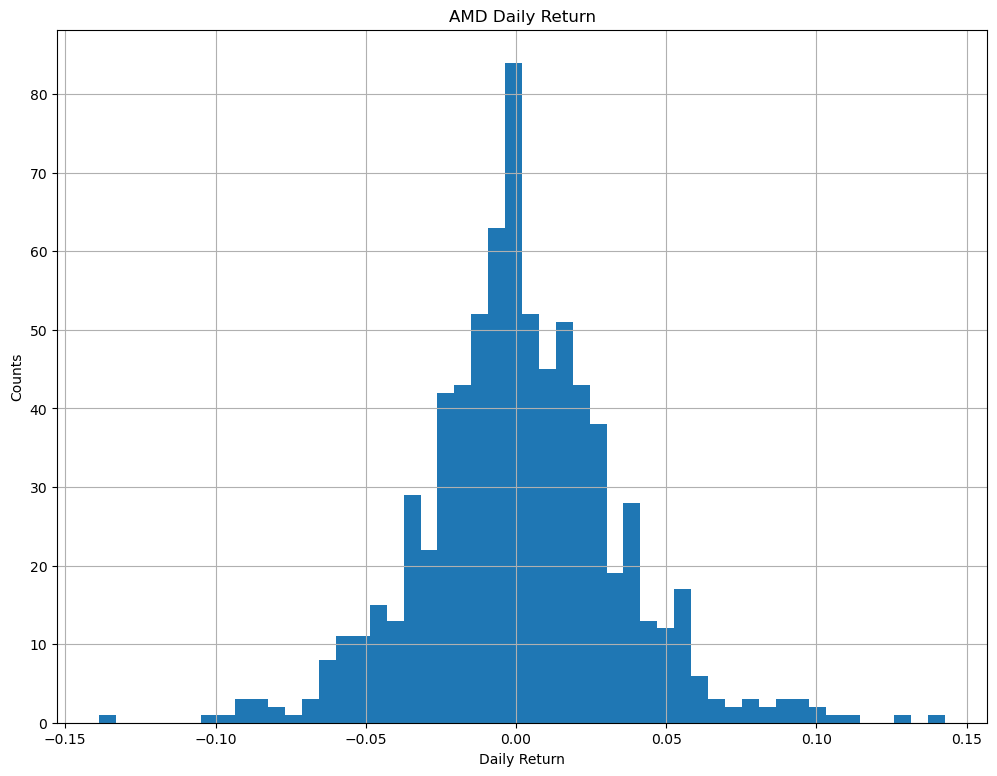

In [57]:
plt.figure(figsize=(12,9))

df_amd['Daily Return'].hist(bins=50)
plt.xlabel('Daily Return')
plt.ylabel('Counts')
plt.title('AMD Daily Return')

What is the risk for investing into the stock?

In [58]:
closing_df = pdr.get_data_yahoo(stock, start=start, end=end)['Adj Close']
tech_rets = closing_df.pct_change()

[*********************100%%**********************]  1 of 1 completed


Text(50, 50, 'AMD')

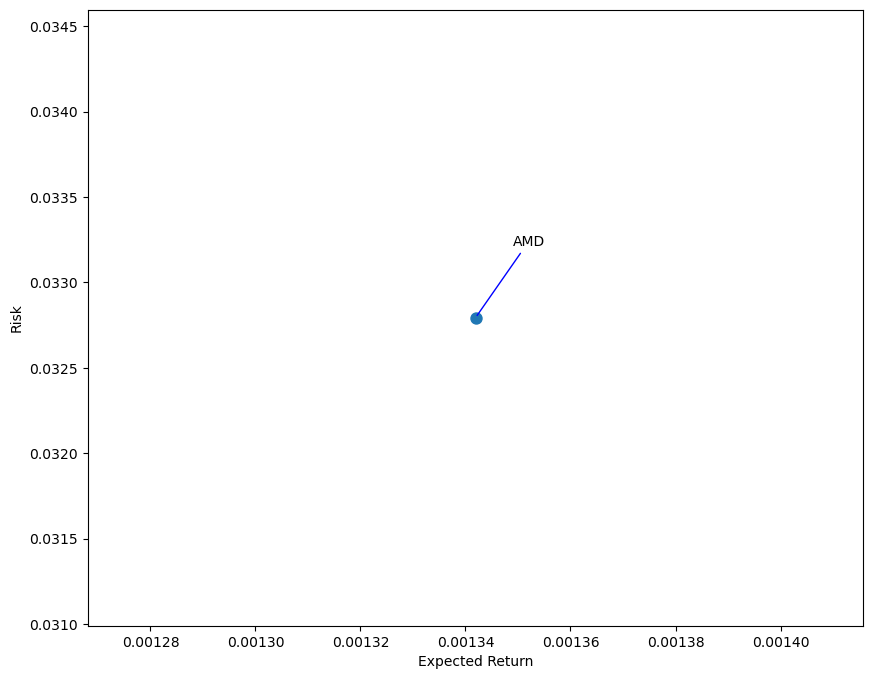

In [59]:
rets = tech_rets.dropna()

area = np.pi * 20

plt.figure(figsize=(10,8))
plt.scatter(rets.mean(), rets.std(), s=area)
plt.xlabel('Expected Return')
plt.ylabel('Risk')

plt.annotate(stock, xy=(rets.mean(), rets.std()), xytext=(50,50), textcoords='offset points', ha='right', va='bottom', arrowprops=dict(arrowstyle='-', color='blue'))

## Prediction Model

In [60]:
start = datetime(end.year - 5, end.month, end.day)
df_amd = pdr.get_data_yahoo('AMD', start=start, end=end)
#getting larger dataset for research

[*********************100%%**********************]  1 of 1 completed


In [61]:
df_amd.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-05-02,26.940001,28.639999,26.610001,28.290001,28.290001,100514800
2019-05-03,28.299999,28.420000,27.660000,28.219999,28.219999,55503100
2019-05-06,26.719999,27.500000,26.450001,27.420000,27.420000,70344100
2019-05-07,27.200001,27.350000,26.209999,26.660000,26.660000,75868800
2019-05-08,26.410000,27.709999,26.270000,27.090000,27.090000,65967500


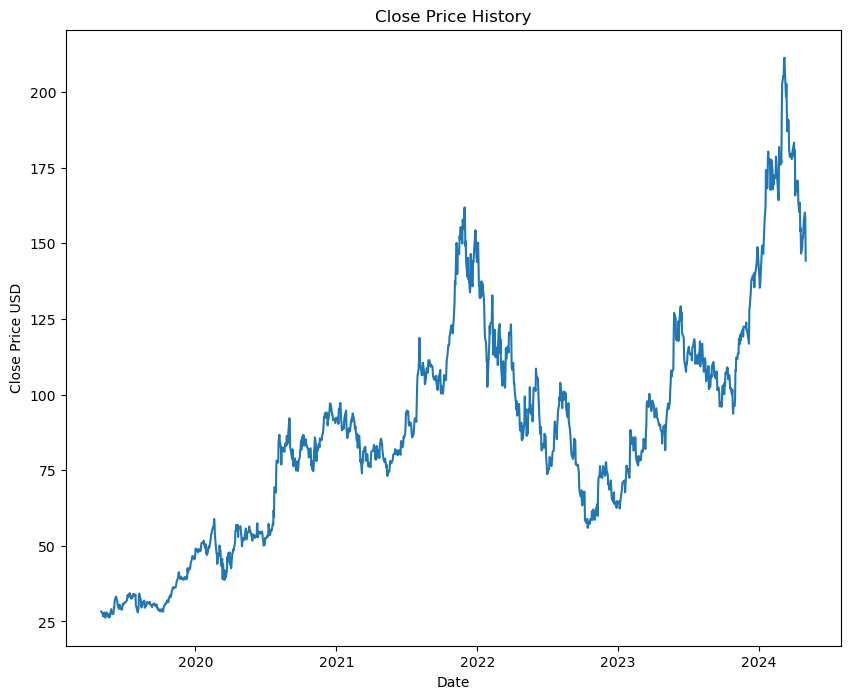

In [62]:
plt.figure(figsize=(10,8))
plt.title('Close Price History')
plt.plot(df_amd['Close'])
plt.xlabel('Date')
plt.ylabel('Close Price USD')
plt.show()

In [95]:
X = df_amd[['High', 'Low', 'Open']]  # Features
y = df_amd['Close']  # Target variable

# Create new dataframe with only 'Close' column
data = df_amd.filter(['Close'])
# convert dataframe to numpy array
dataset = data.values
# get number of rows to train the model on
training_data_len = int(np.ceil(len(dataset) * .95))

training_data_len

1197

In [98]:
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(dataset)

scaled_prices

array([[0.01107271],
       [0.01069461],
       [0.00637356],
       ...,
       [0.72356051],
       [0.71373016],
       [0.63751756]])

In [100]:
window_size = 60

# Create sequences
X, y = [], []
for i in range(len(scaled_prices) - window_size):
    X.append(scaled_prices[i:i+window_size])
    y.append(scaled_prices[i+window_size])

X, y = np.array(X), np.array(y)

In [102]:
# Define the LSTM model
model = Sequential([
    LSTM(units=50, activation='relu', input_shape=(window_size, 1)),
    Dense(units=1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [106]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/100
30/30 [==============================] - 2s 38ms/step - loss: 0.0505 - val_loss: 0.0042
Epoch 2/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0046 - val_loss: 0.0023
Epoch 3/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 4/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0018 - val_loss: 0.0013
Epoch 5/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 6/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 7/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 8/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0013 - val_loss: 9.9987e-04
Epoch 9/100
30/30 [==============================] - 1s 19ms/step - loss: 0.0012 - val_loss: 9.8714e-04
Epoch 10/100
30/30 [==============================] - 1s 18ms/step - loss: 0.0012 - val_loss

In [ ]:
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [107]:
y_pred = model.predict(X_test)
scaled_pred = scaler.inverse_transform(y_pred)

8/8 [==============================] - 0s 7ms/step


In [ ]:
# Plot the data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = scaled_pred

In [108]:
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

ValueError: Length of values (240) does not match length of index (62)

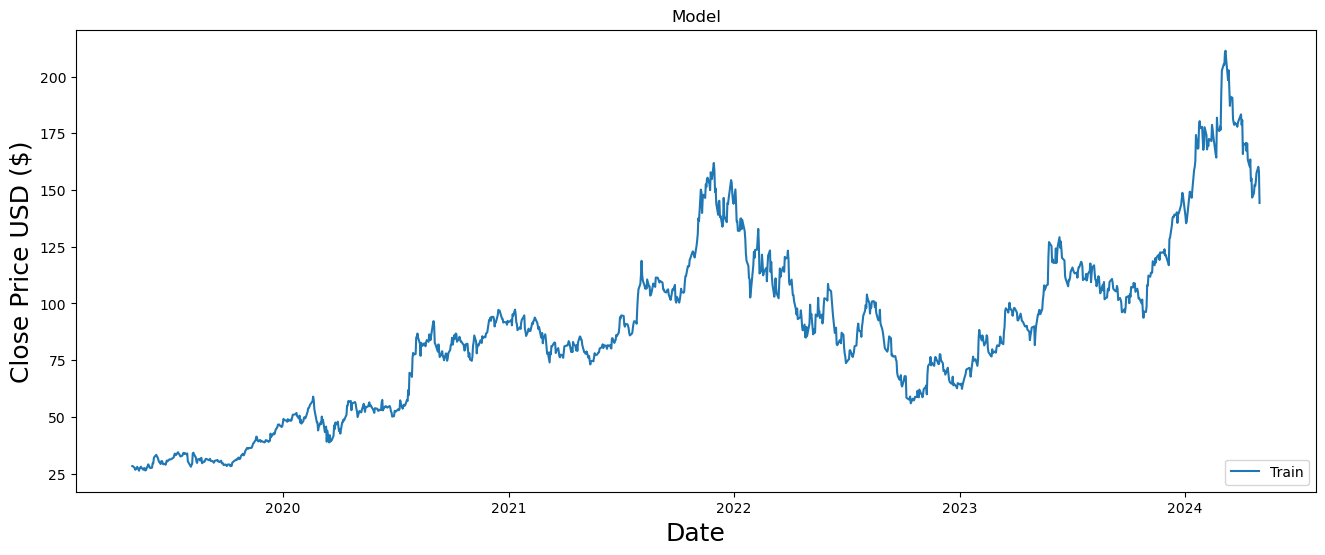

In [ ]:
plt.figure(figsize=(16,6))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(df_amd['Close'])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
loss = model.evaluate(x_test, y_test)

print('Test Loss:', loss)
print('Mean Squared Error:', mse)
print('Root Mean Squared Error:', rmse)
print('R-squared (R2) Score:', r2)

In [ ]:
valid

,Close,Predictions
Date,,
2024-02-02,177.660004,167.151291
2024-02-05,174.229996,167.430283
2024-02-06,167.880005,167.929596
2024-02-07,170.940002,167.033051
2024-02-08,169.350006,166.534622
...,...,...
2024-04-25,153.759995,146.996567
2024-04-26,157.399994,147.841202
2024-04-29,160.199997,149.770538


## Prediction

In [ ]:
last_60_days = scaled_data[-60:]

x_predict = np.reshape(last_60_days, (1,60,1))

predicted_value = model.predict(x_predict)

predicted_decimal = scaler.inverse_transform(predicted_value)

print("Predicted Decimal Value for the Next Day:", predicted_decimal[0][0])

1/1 [==============================] - 0s 43ms/step
Predicted Decimal Value for the Next Day: 152.13298
